<a href="https://colab.research.google.com/github/jamelof23/ASL/blob/main/PrivAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Codebase and Models

In [1]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/genforce/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 613, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 613 (delta 94), reused 92 (delta 92), pack-reused 489 (from 1)
Receiving objects: 100% (613/613), 13.72 MiB | 15.08 MiB/s, done.
Resolving deltas: 100% (204/204), done.


# Define Utility Functions

In [12]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

# A dictionary containing information about the models available (e.g., pggan, stylegan).
from models.model_settings import MODEL_POOL

from models.stylegan_generator import StyleGANGenerator



def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  return generator


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  # Extracting the Shape of the Images
  num, height, width, channels = images.shape
  #Ensures that the number of images (num) is divisible by the number of columns (col).
  #This makes sure that the images can be arranged into a complete grid without leaving any empty cells.
  assert num % col == 0
  #Computes the number of rows needed to fit all the images in the grid.
  row = num // col

  #Creates an empty canvas (a blank image) to hold all the images in a grid format.
  #The canvas has dimensions (viz_size * row, viz_size * col, channels), where:
  #viz_size * row: Total height of the grid.
  #viz_size * col: Total width of the grid.
  #channels: Number of color channels (same as the input images).
  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  #Placing Each Image on the Canvas
  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    #Resizing and Copying Each Image to the Canvas
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  #Converting the Canvas to a Displayable Format
  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  #Displaying the Image Using IPython
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [13]:
# This line is a special Jupyter Notebook cell annotation for display and auto-run in notebooks
#@title { display-mode: "form", run: "auto" }

# Fixed parameters
model_name = "stylegan_ffhq"  # Always use 'stylegan_ffhq'
latent_space_type = "W"       # Always use latent space type 'W'

# Function to build and load the generator model
generator = build_generator(model_name)

# List of attributes for manipulation
ATTRS = ['age', 'eyeglasses', 'gender', 'pose', 'smile']
# Dictionary to store attribute boundaries
boundaries = {}

# Loading Attribute Boundaries
for attr_name in ATTRS:
    boundary_name = f'{model_name}_{attr_name}'
    # Load the correct boundary file based on the latent space type
    boundary_path = f'boundaries/{boundary_name}_w_boundary.npy'
    boundaries[attr_name] = np.load(boundary_path)


# Upload latent codes

[INFO] Please upload your latent vector (.npy file):


Saving your_latent_vector.npy to your_latent_vector (4).npy


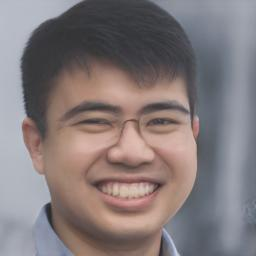

In [15]:
import numpy as np

# Upload the .npy file
print("[INFO] Please upload your latent vector (.npy file):")
uploaded = files.upload()

# Load the uploaded latent vector
npy_file_name = list(uploaded.keys())[0]
latent_codes = np.load(npy_file_name)

# Ensure that the latent vector is in the correct format (numpy.ndarray) and shape
if not isinstance(latent_codes, np.ndarray) or latent_codes.shape != (1, 512):
    raise ValueError(f"Latent codes must be a numpy.ndarray with shape (1, 512), but got {latent_codes.shape}")

# Use W space for StyleGAN synthesis
synthesis_kwargs = {'latent_space_type': 'W'}

# Generate the image using your custom latent vector
images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']

# Display the generated images using your imshow function
imshow(images, col=1)


# Adding Noise

In [ ]:
import numpy as np

# Differential Privacy Parameters (Slider Values)
epsilon = 5  # @param {"type":"slider","min":0.01,"max":5,"step":0.01}
delta = 0.001  # @param {type:"slider", min:1e-7, max:1e-3, step:1e-7}
clipping_threshold = 0.1  # @param {type:"slider", min:0.1, max:5.0, step:0.1}

# Dropdown Menu for Attribute Selection
attribute_selection = "Age"  # @param ["Age", "Gender", "Both"]

# Sliders for the Selected Attributes
if attribute_selection in ["Age", "Both"]:
    age = 1  # @param {type:"slider", min:0.0, max:3.0, step:0.1}
else:
    age = 0  # Disable age if not selected

if attribute_selection in ["Gender", "Both"]:
    gender = 1  # @param {type:"slider", min:0.0, max:3.0, step:0.1}
else:
    gender = 0  # Disable gender if not selected

# Function to add Gaussian noise for differential privacy
def add_gaussian_noise(epsilon, delta, boundary):
    """
    Adds Gaussian noise to a vector for differential privacy.

    Args:
        epsilon (float): Privacy budget.
        delta (float): Probability of failure.
        boundary (np.ndarray): Attribute boundary vector.

    Returns:
        np.ndarray: Noise scaled by boundary.
    """
    # Compute the standard deviation for Gaussian noise
    sigma = np.sqrt(2 * np.log(1.25 / delta)) / epsilon

    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, boundary.shape)

    # Return the noise scaled by the boundary
    return boundary * noise

# Copy the original latent codes
new_codes = latent_codes.copy()

# Add noise only to the selected attributes
for attr_name in ["age", "gender"]:  # Only iterate over selected attributes
    attr_value = eval(attr_name)  # Get the slider value for the current attribute

    # Skip attributes with a slider value of 0
    if attr_value == 0:
        continue

    # Add Gaussian noise to the boundary
    noised_boundary = add_gaussian_noise(
        epsilon=epsilon,
        delta=delta,
        boundary=boundaries[attr_name]
    )

    # Add the noise-modified boundary to the latent codes
    new_codes += noised_boundary * attr_value

# Apply clipping as the final step
new_codes = np.clip(new_codes, -clipping_threshold, clipping_threshold)

# Generate and display the new images
new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)
